## Two tasks learning in teacher-student setup

### Import modules

In [1]:
from data import iid
from network import teacher, student, base, ensemble
from solver import teacher_student_solver
from sklearn import linear_model
import torch.nn as nn
import torch

import matplotlib.pyplot as plt

<h3>Define data sampler</h3>

Each element of $\textbf{x} \in \mathbb{R}^{D}$ is $\textit{i.i.d}$ sampled from a unit normal distribution $\mathcal{N}(0,1)$.  
$\textit{IIDTask}$ module will sample $B*D$ datapoints of where $B$ is a batchsize.

In [2]:
D = 100
iid_task = iid.IIDTask(batch_size = 512 , continuous_input_dim = D , binary_input_dim = 0)

<h3>Define teacher-student networks</h3>

We will have two single layer teacher networks where each network represents each task and have two modules one computing binary task flag and the other computing continuous variable.  
Binary teacher label $y^*_{b_i} \in \{0,1\}$ is defined by $y^*_{b_i}=\mathcal{Heaviside}\left(\frac{\textbf{W}^*_{b_i} \cdot \textbf{x}}{\sqrt{N_{b_i}}}\right) $ and continuous teacher label $y^*_{c_i} \in \mathbb{R}$ is defined by $y^*_{c_i}= \frac{\textbf{W}^*_{c_i} \cdot \textbf{x}}{\sqrt{N_{c_i}}} $ where $i$ denotes task index, $i \in \{1,2\}$.  
In other words, we will have 2 sets of a binary task flag and continuous value representing each task, 4D output vector from teacher network for each $\textbf{x}$.

Student network has the same structure but using $sigmoid$ instead of $heaviside$ for the ease of gradient descent.

Both teacher networks and student networks weights are initialized with unit normal distribution (with bias term). 

In [3]:
task1_teacher_binary = teacher.BinaryTeacher(input_dimension = D, hidden_dimensions=[1])
task1_teacher_conti = teacher.ContinuousTeacher(input_dimension = D, hidden_dimensions=[1])

task2_teacher_binary = teacher.BinaryTeacher(input_dimension = D, hidden_dimensions=[1])
task2_teacher_conti = teacher.ContinuousTeacher(input_dimension = D, hidden_dimensions=[1])


In [4]:
task1_student_binary = student.BinaryStudent(input_dimension = D, hidden_dimensions=[1])
task1_student_conti = student.ContinuousStudent(input_dimension = D, hidden_dimensions=[1])

task2_student_binary = student.BinaryStudent(input_dimension = D, hidden_dimensions=[1])
task2_student_conti = student.ContinuousStudent(input_dimension = D, hidden_dimensions=[1])


In [5]:
teacher_ensemble=ensemble.Ensemble([task1_teacher_binary, task1_teacher_conti, task2_teacher_binary, task2_teacher_conti])

In [6]:
student_ensemble=ensemble.Ensemble([task1_student_binary, task1_student_conti, task2_student_binary, task2_student_conti],)

<h3>Pre-train student neural network</h3>

We train the student neural network with elementwise MSE loss between teacher output and student output using SGD;  

$\mathcal{L}= \frac{1}{B}\sum_{n=1}^{B}\left(\sum_{i=1}^{4}(y^*_{n_i}-\hat y_{n_i})^2\right) $

Since during the pre-training, we do not want to show the network "composite task" or a datapoint which do not belong to any of the task, we reject the samples of $y_{b_1} = y_{b_2}$

In [7]:
## learning rate and L2 regularizer weight is randomly set, but seems to be pretty robust
solver=teacher_student_solver.TeacherStudentElementwiseRegressionSolver(criterion = nn.MSELoss(reduction='none'), lr = 0.1, weight_decay = 1e-3,
                                                              optimizer_type = "sgd", logdir = "", teacher_network = teacher_ensemble, 
                                                                     student_network = student_ensemble)

In [8]:
## Reject samples for training where yb1 = yb2
def rejection_intersect_task(x, teacher_outputs):
    #accept_index = torch.where((teacher_outputs[0] != teacher_outputs[2]))[0]
    accept_index = torch.where((teacher_outputs[0].squeeze()==0) | (teacher_outputs[2].squeeze()==0) )[0]
    new_x = x[accept_index, :]
    if len(new_x) == 0:
        return None
    else:
        return new_x
    
solver.train(data_loader = iid_task, num_iter = 3000, rejection_func = rejection_intersect_task)

<h3>Visualize training result</h3>

Simple visualization of loss and true/prediction values.

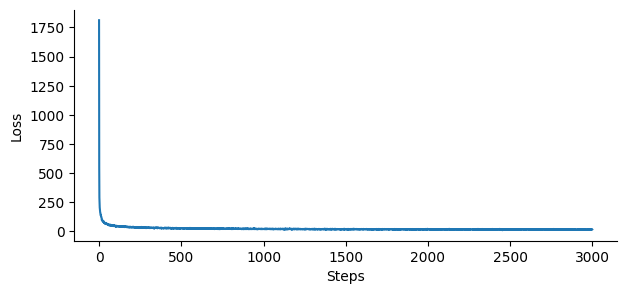

In [9]:
plt.figure(figsize=(7,3))
ax1 = plt.subplot(111)
ax1.plot(solver.history['loss'])
ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

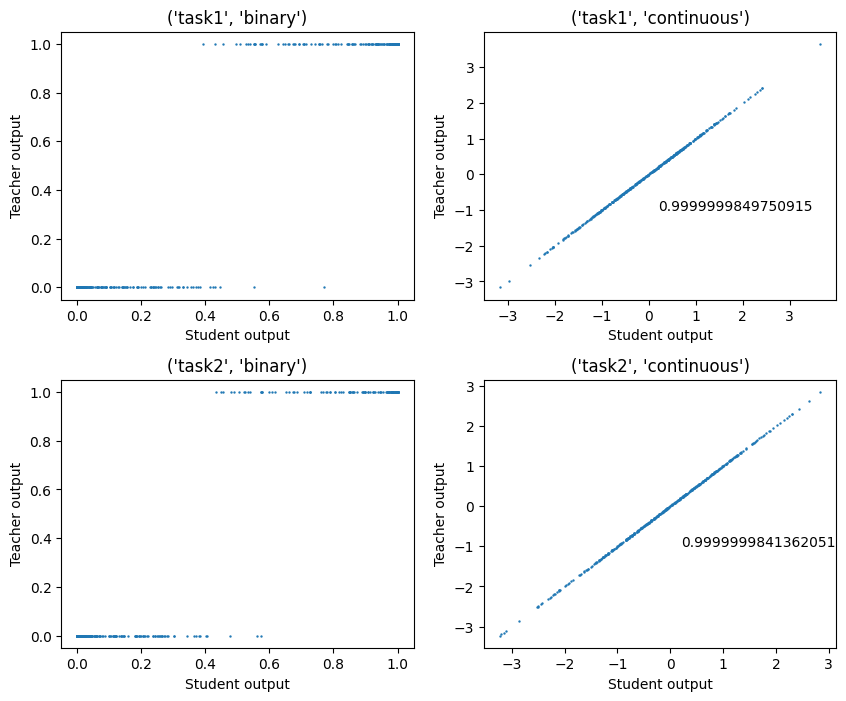

In [39]:
import sklearn
import numpy as np
iter_idx = 2000

plt.figure(figsize=(10,8))
value_type = {0: ('task1', 'binary'), 1: ('task1', 'continuous'), 2: ('task2', 'binary'), 3: ('task2', 'continuous')}
plt.subplots_adjust(hspace=0.3)
for i in range(4):
    ax = plt.subplot(2,2,i+1)
    ax.scatter(solver.history['prediction'][iter_idx][:,i], solver.history['true'][iter_idx][:,i], s=0.5)
    if value_type[i][1]=='continuous':
        r2=sklearn.metrics.r2_score(solver.history['true'][iter_idx][:,i], solver.history['prediction'][iter_idx][:,i])
        ax.text(0.2,-1, r2)
    ax.set_xlabel('Student output')
    ax.set_ylabel('Teacher output')
    ax.set_title(f'{value_type[i]}')

<h2> TODO: Design test phase setup </h2>

In [31]:
## Reject samples for training where yb1 != yb2
def rejection_individual_task(x, teacher_outputs):
    accept_index = torch.where((teacher_outputs[0].squeeze()==1) & (teacher_outputs[2].squeeze()==1) )[0]
    new_x = x[accept_index, :]
    if len(new_x) == 0:
        return None
    else:
        return new_x

x = iid_task.get_batch()['x']
teacher_test_output, student_test_output=solver.inference(x, rejection_func = rejection_individual_task)

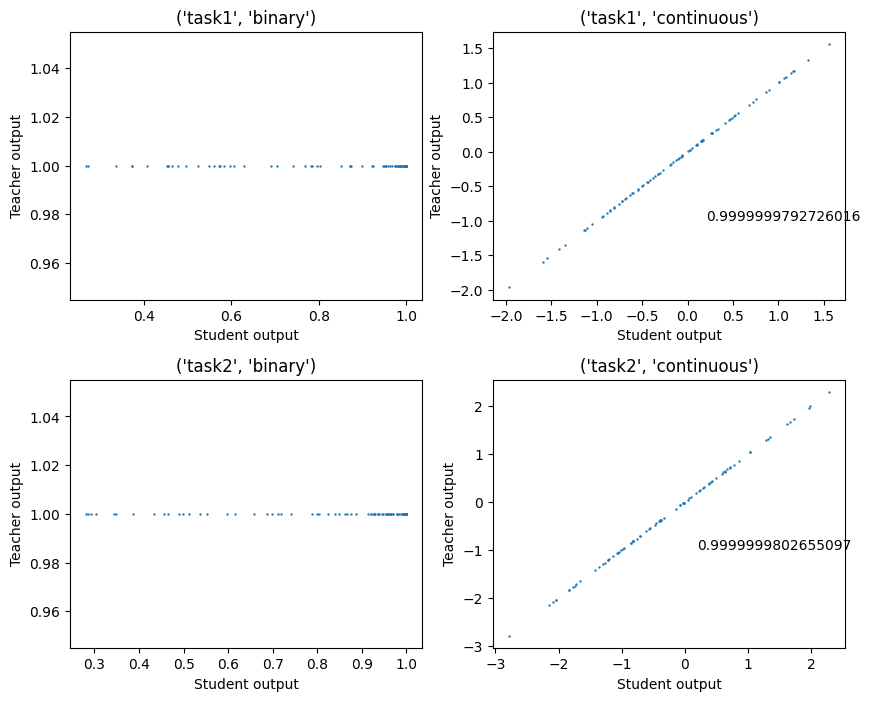

In [38]:
plt.figure(figsize=(10,8))
value_type = {0: ('task1', 'binary'), 1: ('task1', 'continuous'), 2: ('task2', 'binary'), 3: ('task2', 'continuous')}
plt.subplots_adjust(hspace=0.3)
for i in range(4):
    ax = plt.subplot(2,2,i+1)
    ax.scatter(student_test_output[i], teacher_test_output[i], s=0.5)
    if value_type[i][1]=='continuous':
        r2=sklearn.metrics.r2_score(teacher_test_output[i], student_test_output[i])
        ax.text(0.2,-1, r2)
    ax.set_xlabel('Student output')
    ax.set_ylabel('Teacher output')
    ax.set_title(f'{value_type[i]}')

<h3>Observation</h3>

When the network is pretrained with $(b1, b2) \in {(1,0), (0,1)}$ case only,  
the student network cannot correctly make task flag prediction.  
If we train with $(b1, b2) \in {(1,0), (0,1), (0,0)}$, the student network can correctly identify the task flag. 